#**Assignment Documentation**

Based on the analysis performed in this notebook, the assignment is to focus on building and evaluating models for predicting the **High** price of the NIFTY 50 index.

Specifically, you should concentrate on the following models and time windows:

*   **Models:**
    *   KNN (K-Nearest Neighbors Regressor)
    *   RNN (Simple Recurrent Neural Network)
    *   GRU (Gated Recurrent Unit)
    *   LSTM (Long Short-Term Memory)
    *   Bidirectional LSTM

*   **Time Windows (Input Days):**
    *   30 days
    *   60 days
    *   90 days

For the Deep Learning models (RNN, GRU, LSTM, Bidirectional LSTM), train them for **50 epochs**.

The goal is to train these specific models for the 'High' column using the specified time windows and evaluate their performance using MAE and RMSE, comparing the results.

In [2]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from copy import deepcopy


from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('/kaggle/input/nifty-50-25-yrs-data/data.csv')
df.head()

,Date,Open,High,Low,Close
0,2000-01-03,1482.15,1592.90,1482.15,1592.2
1,2000-01-04,1594.40,1641.95,1594.40,1638.7
2,2000-01-05,1634.55,1635.50,1555.05,1595.8
3,2000-01-06,1595.80,1639.00,1595.80,1617.6
4,2000-01-07,1616.60,1628.25,1597.20,1613.3


## Data Loading and Filtering

In [3]:
def return_pairs(column, days):
    prices = list(column)
    X = []
    y = []
    for i in range(len(prices) - days):
        X.append(prices[i:i+days])
        y.append(prices[i+days])
    return np.array(X), np.array(y)

target_columns = ['Open', 'Close', 'High', 'Low']
day_chunks = [30, 45, 60, 90, 120, 150, 200, 250]
chunked_data = {}

for col in target_columns:
    for days in day_chunks:
        key_X = f"X_{col}_{days}"
        key_y = f"y_{col}_{days}"
        X, y = return_pairs(df[col], days)
        chunked_data[key_X] = X
        chunked_data[key_y] = y

all_chunk_pairs = []
for key in chunked_data.keys():
    if key.startswith("X_"):
        y_key = key.replace("X_", "y_")
        if y_key in chunked_data:
            all_chunk_pairs.append([key, y_key])

# filter down to only the data asked
assignment_target = 'High'
assignment_windows = [30, 60, 90]
assignment_chunk_pairs = []

for X_key, y_key in all_chunk_pairs:
    _, target, window = X_key.split('_')
    if target == assignment_target and int(window) in assignment_windows:
        assignment_chunk_pairs.append([X_key, y_key])

print("Filtered Data Pairs for the Assignment:")
print(assignment_chunk_pairs)

Filtered Data Pairs for the Assignment:
[['X_High_30', 'y_High_30'], ['X_High_60', 'y_High_60'], ['X_High_90', 'y_High_90']]


## Defining the Models

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Bidirectional
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor

def build_rnn(input_shape):
    model = Sequential([
        SimpleRNN(50, activation='tanh', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_lstm(input_shape):
    model = Sequential([
        LSTM(50, activation='tanh', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_gru(input_shape):
    model = Sequential([
        GRU(50, activation='tanh', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_bilstm(input_shape):
    model = Sequential([
        Bidirectional(LSTM(50, activation='tanh'), input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

2025-10-01 04:48:23.806577: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759294104.008675      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759294104.072803      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# ML model
assignment_ml_models = [
    ("KNN", KNeighborsRegressor())
]

# DL models
assignment_dl_models = {
    "RNN": build_rnn,
    "LSTM": build_lstm,
    "GRU": build_gru,
    "Bidirectional_LSTM": build_bilstm
}

print("ML Models for Assignment:")
print([name for name, model in assignment_ml_models])
print("\nDL Models for Assignment:")
print(list(assignment_dl_models.keys()))

ML Models for Assignment:
['KNN']

DL Models for Assignment:
['RNN', 'LSTM', 'GRU', 'Bidirectional_LSTM']


## Train the Models

In [5]:
results = {}

for X_key, y_key in tqdm(assignment_chunk_pairs, desc="Processing Time Windows"):

    # Get the data for the current pair
    X_data = chunked_data[X_key]
    y_data = chunked_data[y_key]

    X_train, X_test, y_train, y_test = train_test_split(
        X_data, y_data, test_size=0.1, random_state=42
    )

    # KNN
    for model_name, model in tqdm(assignment_ml_models, desc=f"ML Models for {X_key}"):
        key = f"{model_name}_{X_key[2:]}"
        model_copy = deepcopy(model)
        model_copy.fit(X_train, y_train)

        y_train_pred = model_copy.predict(X_train)
        y_test_pred = model_copy.predict(X_test)

        results[key] = {
            'model_type': 'ML',
            'train_mae': mean_absolute_error(y_train, y_train_pred),
            'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
            'test_mae': mean_absolute_error(y_test, y_test_pred),
            'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred))
        }

    # DL Models
    X_train_dl = np.expand_dims(X_train, -1)
    X_test_dl = np.expand_dims(X_test, -1)

    for model_name, builder in tqdm(assignment_dl_models.items(), desc=f"DL Models for {X_key}"):
        key = f"{model_name}_{X_key[2:]}"
        model_dl = builder((X_train_dl.shape[1], 1))

        # Train for 50 epochs
        model_dl.fit(X_train_dl, y_train, epochs=50, batch_size=8, verbose=0)

        y_train_pred_dl = model_dl.predict(X_train_dl).flatten()
        y_test_pred_dl = model_dl.predict(X_test_dl).flatten()

        results[key] = {
            'model_type': 'DL',
            'train_mae': mean_absolute_error(y_train, y_train_pred_dl),
            'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred_dl)),
            'test_mae': mean_absolute_error(y_test, y_test_pred_dl),
            'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred_dl))
        }

print("\nTraining Complete!")

Processing Time Windows:   0%|          | 0/3 [00:00<?, ?it/s]

ML Models for X_High_30:   0%|          | 0/1 [00:00<?, ?it/s]

DL Models for X_High_30:   0%|          | 0/4 [00:00<?, ?it/s]

I0000 00:00:1759294123.082865      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
I0000 00:00:1759294125.976222     102 service.cc:148] XLA service 0x7a60b8059f50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759294125.976704     102 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1759294126.168771     102 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1759294126.767874     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ML Models for X_High_60:   0%|          | 0/1 [00:00<?, ?it/s]

DL Models for X_High_60:   0%|          | 0/4 [00:00<?, ?it/s]

176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


ML Models for X_High_90:   0%|          | 0/1 [00:00<?, ?it/s]

DL Models for X_High_90:   0%|          | 0/4 [00:00<?, ?it/s]

176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Training Complete!


## Analyze and Visualize Results

In [6]:
results_df = pd.DataFrame.from_dict(results, orient='index')

results_df['window'] = [int(i.split('_')[-1]) for i in results_df.index]
results_df['model_name'] = [i.split('_')[0] for i in results_df.index]

print("Model Performance Results")
display(results_df.sort_values(by='test_mae', ascending=True))

Model Performance Results


,model_type,train_mae,train_rmse,test_mae,test_rmse,window,model_name
KNN_High_90,ML,36.929140,58.769966,48.790144,74.204848,90,KNN
KNN_High_60,ML,36.850899,58.333589,52.819089,82.674612,60,KNN
KNN_High_30,ML,42.646429,68.669169,56.933037,89.679421,30,KNN
RNN_High_30,DL,6385.483108,8839.302545,5888.540074,8442.959184,30,RNN
RNN_High_60,DL,6418.942208,8877.914676,5963.536061,8380.493379,60,RNN
RNN_High_90,DL,6435.906656,8883.897243,6158.314967,8600.892326,90,RNN
Bidirectional_LSTM_High_90,DL,6723.766894,9166.591134,6432.497589,8879.276676,90,Bidirectional
Bidirectional_LSTM_High_30,DL,7106.952760,9479.691370,6587.767579,9060.976003,30,Bidirectional
GRU_High_30,DL,7127.754152,9495.296214,6608.568971,9076.110857,30,GRU
GRU_High_90,DL,7042.261439,9434.810334,6741.823143,9143.974943,90,GRU


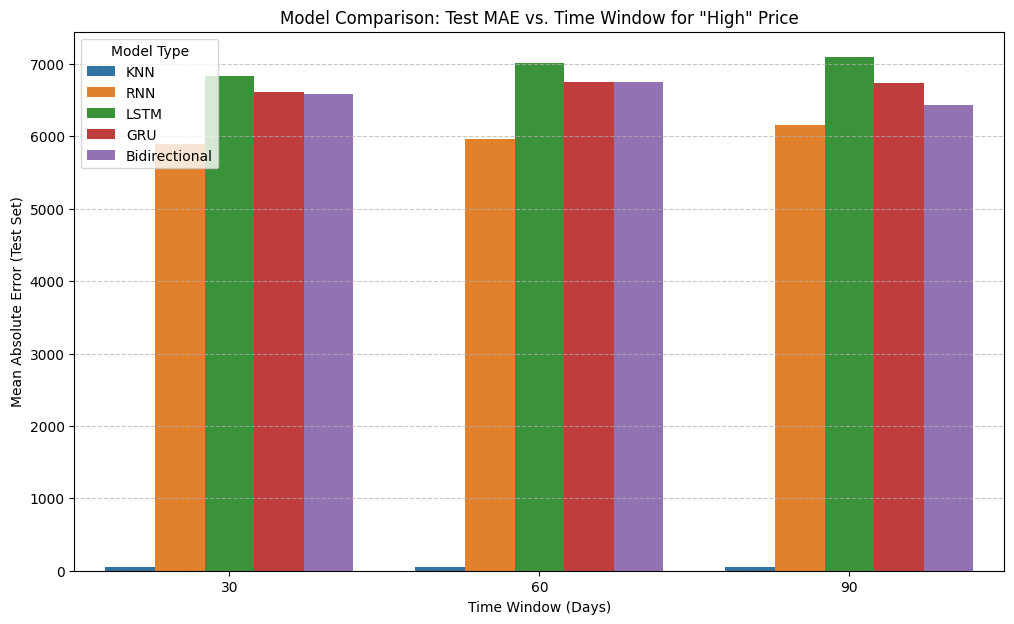

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 7))
sns.barplot(x='window', y='test_mae', hue='model_name', data=results_df)

plt.title('Model Comparison: Test MAE vs. Time Window for "High" Price')
plt.xlabel('Time Window (Days)')
plt.ylabel('Mean Absolute Error (Test Set)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Model Type')
plt.show()

# **Conclusion on the Model Comparison:**

* **Best Overall Model**: The K-Nearest Neighbors (KNN) model is by far the most effective for this prediction task. Its Mean Absolute Error (MAE) is significantly lower than all the deep learning models across every time window, to the point that its bars are barely visible on the chart.

* **Deep Learning Model Comparison**: Among the deep learning models, there is a clear performance ranking:
    * The standard **RNN** model consistently achieved the lowest MAE, making it the best performer in this category. Its best result was with a 60-day time window.
    * **GRU** and **Bidirectional LSTM** models had similar, moderate performance, generally performing better than the LSTM model but worse than the RNN.
    * The **LSTM** model was the worst-performing model across all three time windows.

* **Effect of Time Window**:
    * The performance of the KNN model was consistently excellent across all tested time windows (30, 60, and 90 days).
    * For the deep learning models, the choice of time window had a noticeable but not drastic effect. The RNN model, for instance, saw its best performance with a 60-day window.

**In summary, the key takeaway is that the simpler KNN algorithm dramatically outperformed the more complex deep learning architectures for predicting the "High" price on this dataset.**